# TRAINING JUPYTER

### Parameter setting

In [12]:
# Imports et variables setting

# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Up_and_Down_Generator, FC_Generator
from preprocess import Level_Normalizer, DictPrepross

from utils import Load_FLX_dict, Plot_Batch
from CST import CST


data_folder=  CST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

##### Dictionnary
seed=0
np.random.seed(seed)

D2 = []
D2 = [DictPrepross(['o3','pl'], [Level_Normalizer(False),Level_Normalizer(False)] )]
D = [Load_FLX_dict()]
##### Kernels

Klist = []
fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=512, train=True, preprocess_x=D)
D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])

##### Full Preprocessing :
FP = D + D2 #+ Klist
##### b_size
batch_size= 64

train_generator =  FC_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP,custom_b_p_e = 500)
validation_generator =  FC_Generator(folder=data_folder, batch_size=5*batch_size, train=False, preprocess_x=FP, custom_b_p_e = 50)

header_x = train_generator.variables
header_y = train_generator.new_variables_pred

## II) ARCHITECTURES

### FC

In [13]:
from architectures import FC_archi, LossHistory, Generate_Log, Bidir_Causal_Conv
from architectures import total_loss_fc, flxd_loss_fc, flxu_loss_fc, dfdts_loss_fc

from keras import optimizers
import datetime
ups=5
pooling=22
units = [300, 150, 64, 25, 64, 150, 72*3]

prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = "FC"

#M_ffc = FFC_archi(ups=ups, pooling=pooling, BS=batch_size, list_of_unit=units )
M = FC_archi(ups, pooling, units, batch_size, reg=0.0001, o_channel=3, lev= 72, unique_var = 3, level_var=8)

LH = LossHistory()
rmsprop = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=1.e-6)
M.compile(loss=total_loss_fc, optimizer=rmsprop, metrics=[flxd_loss_fc,flxu_loss_fc, dfdts_loss_fc])
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLev_0 (InputLayer)         (64, 72, 8)          0                                            
__________________________________________________________________________________________________
Up_0 (UpSampling1D)             (64, 360, 8)         0           InputLev_0[0][0]                 
__________________________________________________________________________________________________
AVG_1 (AveragePooling1D)        (64, 72, 8)          0           Up_0[0][0]                       
__________________________________________________________________________________________________
Flat_0 (Flatten)                (64, 576)            0           AVG_1[0][0]                      
__________________________________________________________________________________________________
InputU_1 (

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:209: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", name="AVG_1", strides=5)`
  o2 = AveragePooling1D(pooling, padding='same', stride=ups, name=Name('AVG',1))(o1)


In [14]:
print(train_generator.current_file,train_generator.current_b, train_generator.current_folder)

2 0 3


In [15]:
history = M.fit_generator(generator=train_generator ,
                    validation_data=validation_generator,
                             shuffle=False,
                               callbacks = [LH],
                               epochs=150,
                               verbose=1)

Epoch 1/150
500/500 [==============================] - 2s 4ms/step - loss: 640.0834 - flxd_loss_fc: 40.0000 - flxu_loss_fc: 16.3655 - dfdts_loss_fc: 583.4835 - val_loss: 82.0530 - val_flxd_loss_fc: 37.3573 - val_flxu_loss_fc: 15.6614 - val_dfdts_loss_fc: 28.6442
Epoch 2/150
500/500 [==============================] - 3s 6ms/step - loss: 53.0266 - flxd_loss_fc: 26.8602 - flxu_loss_fc: 14.4629 - dfdts_loss_fc: 11.2909 - val_loss: 152.3024 - val_flxd_loss_fc: 63.4576 - val_flxu_loss_fc: 23.3435 - val_dfdts_loss_fc: 65.0062
Epoch 3/150
500/500 [==============================] - 3s 5ms/step - loss: 41.6839 - flxd_loss_fc: 19.9398 - flxu_loss_fc: 11.2905 - dfdts_loss_fc: 9.9184 - val_loss: 145.0253 - val_flxd_loss_fc: 59.1983 - val_flxu_loss_fc: 20.3625 - val_dfdts_loss_fc: 64.8784
Epoch 4/150
500/500 [==============================] - 3s 5ms/step - loss: 69.7664 - flxd_loss_fc: 34.8346 - flxu_loss_fc: 13.1890 - dfdts_loss_fc: 21.0981 - val_loss: 86.3755 - val_flxd_loss_fc: 33.2976 - val_flxu

500/500 [==============================] - 3s 6ms/step - loss: 55.6790 - flxd_loss_fc: 31.6138 - flxu_loss_fc: 12.8954 - dfdts_loss_fc: 10.5933 - val_loss: 94.7110 - val_flxd_loss_fc: 40.7560 - val_flxu_loss_fc: 21.6129 - val_dfdts_loss_fc: 31.7569
Epoch 33/150
500/500 [==============================] - 3s 6ms/step - loss: 109.3584 - flxd_loss_fc: 55.5521 - flxu_loss_fc: 17.0244 - dfdts_loss_fc: 36.1943 - val_loss: 72.8313 - val_flxd_loss_fc: 31.9271 - val_flxu_loss_fc: 10.6674 - val_dfdts_loss_fc: 29.6365
Epoch 34/150
500/500 [==============================] - 3s 7ms/step - loss: 56.5907 - flxd_loss_fc: 29.2742 - flxu_loss_fc: 8.7332 - dfdts_loss_fc: 17.9982 - val_loss: 53.2257 - val_flxd_loss_fc: 27.5739 - val_flxu_loss_fc: 8.7334 - val_dfdts_loss_fc: 16.3288
Epoch 35/150
500/500 [==============================] - 3s 6ms/step - loss: 53.9248 - flxd_loss_fc: 27.7249 - flxu_loss_fc: 8.6239 - dfdts_loss_fc: 16.9669 - val_loss: 54.8746 - val_flxd_loss_fc: 27.5804 - val_flxu_loss_fc: 8.91

500/500 [==============================] - 3s 7ms/step - loss: 50.7048 - flxd_loss_fc: 26.4852 - flxu_loss_fc: 7.9823 - dfdts_loss_fc: 15.6114 - val_loss: 67.5814 - val_flxd_loss_fc: 32.7350 - val_flxu_loss_fc: 16.5142 - val_dfdts_loss_fc: 17.6943
Epoch 64/150
500/500 [==============================] - 3s 6ms/step - loss: 44.3064 - flxd_loss_fc: 23.7048 - flxu_loss_fc: 11.5740 - dfdts_loss_fc: 8.4203 - val_loss: 55.4209 - val_flxd_loss_fc: 31.1514 - val_flxu_loss_fc: 12.8013 - val_dfdts_loss_fc: 10.8668
Epoch 65/150
500/500 [==============================] - 4s 7ms/step - loss: 106.6229 - flxd_loss_fc: 53.8458 - flxu_loss_fc: 16.9171 - dfdts_loss_fc: 35.2693 - val_loss: 108.6311 - val_flxd_loss_fc: 55.4302 - val_flxu_loss_fc: 16.8166 - val_dfdts_loss_fc: 35.7889
Epoch 66/150
500/500 [==============================] - 3s 6ms/step - loss: 53.3019 - flxd_loss_fc: 29.2662 - flxu_loss_fc: 13.0667 - dfdts_loss_fc: 10.3790 - val_loss: 88.9793 - val_flxd_loss_fc: 39.7107 - val_flxu_loss_fc: 18

500/500 [==============================] - 3s 6ms/step - loss: 64.6818 - flxd_loss_fc: 33.2188 - flxu_loss_fc: 12.0595 - dfdts_loss_fc: 18.8332 - val_loss: 65.6169 - val_flxd_loss_fc: 36.2653 - val_flxu_loss_fc: 15.4985 - val_dfdts_loss_fc: 13.2761
Epoch 95/150
500/500 [==============================] - 3s 7ms/step - loss: 55.1789 - flxd_loss_fc: 29.0154 - flxu_loss_fc: 8.8738 - dfdts_loss_fc: 16.7162 - val_loss: 66.3206 - val_flxd_loss_fc: 32.4243 - val_flxu_loss_fc: 16.3123 - val_dfdts_loss_fc: 17.0020
Epoch 96/150
500/500 [==============================] - 3s 6ms/step - loss: 52.9271 - flxd_loss_fc: 27.7297 - flxu_loss_fc: 8.5468 - dfdts_loss_fc: 16.0596 - val_loss: 73.3649 - val_flxd_loss_fc: 33.9758 - val_flxu_loss_fc: 16.8949 - val_dfdts_loss_fc: 21.8949
Epoch 97/150
500/500 [==============================] - 3s 6ms/step - loss: 59.1733 - flxd_loss_fc: 30.3656 - flxu_loss_fc: 15.5445 - dfdts_loss_fc: 12.6828 - val_loss: 70.6293 - val_flxd_loss_fc: 32.2478 - val_flxu_loss_fc: 11.5

500/500 [==============================] - 3s 6ms/step - loss: 53.0273 - flxd_loss_fc: 29.3013 - flxu_loss_fc: 13.0944 - dfdts_loss_fc: 10.0276 - val_loss: 105.9023 - val_flxd_loss_fc: 41.5603 - val_flxu_loss_fc: 21.5015 - val_dfdts_loss_fc: 42.2377
Epoch 126/150
500/500 [==============================] - 3s 6ms/step - loss: 34.8748 - flxd_loss_fc: 16.5065 - flxu_loss_fc: 6.4637 - dfdts_loss_fc: 11.3109 - val_loss: 72.0867 - val_flxd_loss_fc: 36.1221 - val_flxu_loss_fc: 16.1945 - val_dfdts_loss_fc: 19.1664
Epoch 127/150
500/500 [==============================] - 3s 6ms/step - loss: 111.3227 - flxd_loss_fc: 56.1699 - flxu_loss_fc: 17.6140 - dfdts_loss_fc: 36.9659 - val_loss: 78.7359 - val_flxd_loss_fc: 38.0286 - val_flxu_loss_fc: 17.8757 - val_dfdts_loss_fc: 22.2737
Epoch 128/150
500/500 [==============================] - 3s 6ms/step - loss: 58.3543 - flxd_loss_fc: 30.2280 - flxu_loss_fc: 15.2031 - dfdts_loss_fc: 12.3670 - val_loss: 106.0738 - val_flxd_loss_fc: 40.6824 - val_flxu_loss_f

In [16]:
print(train_generator.current_file,train_generator.current_b, train_generator.current_folder)

4 0 3


In [21]:
M.save(  os.path.join(model_folder, prefix+archi+'.h5')  )
Generate_Log([M], history, LH, os.path.join(log_folder,prefix+archi+'.txt'), seed)

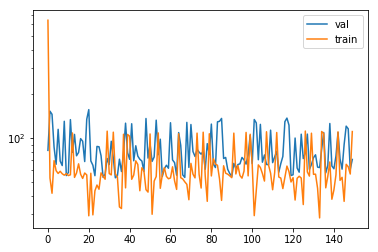

In [22]:
plt.yscale('log')
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['val', 'train'])
plt.show();

dict_keys(['val_loss', 'val_flxd_loss_fc', 'val_flxu_loss_fc', 'val_dfdts_loss_fc', 'loss', 'flxd_loss_fc', 'flxu_loss_fc', 'dfdts_loss_fc'])

### ANALYSIS :

In [ ]:
from contextlib import redirect_stdout
with open(os.path.join(log_folder, prefix), 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        modelbd2.summary()
        modelbd.summary()
        for loss in FP:
            print(loss)
        print(history.history)

### VISUALISATION

In [2]:
# FCT PLOT
def Show_triple_diff(y,y0):
    j = 50 #np.random.randint(0)
    f = plt.figure( figsize=(15,8)   )
    ax = plt.subplot(131)
    lev= 35
    plt.plot(np.flip(y[:,:,0].T[:lev,j]) , np.arange(lev));
    plt.plot(np.flip(y0[:,:,0].T[:lev,j]) , np.arange(lev));
    ax.legend(["truth", "pred"])
    ax = plt.subplot(132)
    plt.plot(np.flip(y[:,:,1].T[:,j]) , np.arange(72));
    plt.plot(np.flip(y0[:,:,1].T[:,j]) , np.arange(72));
    ax.legend(["truth", "pred"])
    ax = plt.subplot(133)
    plt.plot(np.flip(y[:,:,2].T[:,j]) , np.arange(72));
    plt.plot(np.flip(y0[:,:,2].T[:,j]) , np.arange(72));
    ax.legend(["truth", "pred"])

def Difference(y,y0):
#    y_cumsum = np.cumsum(y[i])
#    y0_cumsum = np.cumsum(y0)
    return(  np.mean(np.square(y-y0)))

def Compare(y,y0, i=0):
    f=plt.figure( figsize=(15,8), dpi=80)
    ax= f.add_subplot(1,2,1)
    ax.plot(np.flip(y0[i]), np.arange(len(y0[i]))) 
    ax.plot(np.flip(y[i]), np.arange(len(y0[i]))) 
    ax.legend(["y pred", 'y truth'])
#    ax.title("Diff")
    y_cumsum = np.cumsum(y[i])
    y0_cumsum = np.cumsum(y0[i])
    ax= f.add_subplot(1,2,2)
    ax.plot(np.flip(y0_cumsum), np.arange(len(y0[i])))        
    ax.plot(np.flip(y_cumsum), np.arange(len(y0[i])))        
    ax.legend(["y pred", 'y truth'])
#    ax.title("Cumulative")
    plt.show()

def eliminate_var(m,x):
    O = []
    for i in range(11):
        x0= x.copy()
        x0*=0
        x0[:,:,i]=x[:,:,i]
        O.append(modelbd.predict(x0))
    return(O)

def Plot_Predictions(O, y, header):
    f=plt.figure( figsize=(15,10), dpi=80)
    for i,y0 in enumerate(O):
        ax= f.add_subplot(3,4,i+1)
        ax.set_title(header[i])
        for b in range(y0.shape[0]):
            ax.plot(np.flip(y0[b]), np.arange(len(y0[b])))
    ax= f.add_subplot(3,4,12)
    ax.set_title('flx')
    for b in range(y0.shape[0]):
        ax.plot(np.flip(y[b]), np.arange(len(y[b])))

def Normal2(x,header):
    O1 = []#['fcld', 'q','qi','ql','rl','ri']
    N = [ 'pl']
    STD = []
    STD2 = []
    for i, h in enumerate(header):
        if h in O1:
            x[:,:,i] = np.max(x[:,:,i], axis=1).reshape(x.shape[0],1)
        if h in N:
            #print(h, np.mean(x[:,:,i], axis=0)[32])
            x[:,:,i] -= np.mean(x[:,:,i], axis=0)
        if h in STD:
            x[:,:,i] /= (x[:,-1,i]+0.000000001).reshape(-1,1)         
        if h in STD2:
            x[:,:,i] /= (x[:,0,i]+0.000000001).reshape(-1,1)         
    return(x)


### SECOND ARCHITECTURE :
Not tested yet

# III) TRACKS 

### MODEL 2 :

- FCNN
- (with AE)

##### MODEL 2 : FCM-Final FC

##### MODEL 2 : U-net :
- use regular U-net so all layers affect each other and more stability

### MODEL 3 : Bidir-LSTM 
> Possible alternatives

- use two LSTM to show both impact of superior and inferior layer
- use attention model over it
- use w embeddings before

> TD

- Read git trez
- Read article of Hedge fun